In [1]:
!pip install tensorflow
!pip install cuda-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

2024-07-01 06:20:37.234022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 06:20:37.234071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 06:20:37.235126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 06:20:37.241183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real'.
There are 0 directories and 4061 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/UnRecycle'.
There are 0 directories and 8402 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Organic'.
There are 0 directories and 7552 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Recycle'.


In [5]:
# Đường dẫn đến thư mục chứa dataset
data_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

,Filepath,Label
0,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
1,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
2,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
3,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
4,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
...,...,...
21150,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21151,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21152,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21153,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle


In [7]:
# random_index = np.random.randint(0, len(image_df), 16)
# print(random_index)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
#     ax.set_title(image_df.Label[random_index[i]])
# plt.tight_layout()
# plt.show()
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

train_df.shape

test_df.shape

train_generator = ImageDataGenerator(
rescale=1./255,
validation_split=0.2
)

test_generator = ImageDataGenerator(
rescale=1./255
)

In [8]:
import os

# Định nghĩa các tham số cho dataset
batch_size = 32
img_size = (200, 200)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(img_size[0], img_size[1]),
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='training'
)

val_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(img_size[0], img_size[1]),
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='validation'
)

test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=(img_size[0], img_size[1]),
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=False
)

Found 13540 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.
Found 4231 validated image filenames belonging to 3 classes.


In [9]:
model = models.Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 3))),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2, 2)),
model.add(Conv2D(128, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(256, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(512, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(1024, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Flatten()),
model.add(Dense(1024, activation='relu')),
model.add(BatchNormalization()),
model.add(Dense(3, activation='softmax'))

2024-07-01 06:20:39.602204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 06:20:39.602472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 06:20:39.666879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
# Compile the model
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [11]:
# Set up callbacks
checkpoint_path = '../models/checkpoints/cnn_model_checkpoint.ckpt'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
save_weights_only=True,
save_best_only=True,
monitor='val_accuracy',
verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss',
patience=50)

In [12]:
# Train the model
history = model.fit(train_images,
steps_per_epoch=len(train_images),
epochs=200,
validation_data=val_images,
validation_steps=len(val_images),
callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/200


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2024-07-01 06:20:42.188021: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-01 06:20:42.703770: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 752.11MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 06:20:43.057687: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 752.11MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 06:20:46.803963: I external/local_xla/xla/servi

105/424 [======>.......................] - ETA: 1:17 - loss: 1.2317 - accuracy: 0.6744

2024-07-01 06:21:28.715867: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


424/424 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.7286
Epoch 1: val_accuracy improved from -inf to 0.69297, saving model to ../models/checkpoints/cnn_model_checkpoint.ckpt
424/424 [==============================] - 161s 335ms/step - loss: 0.7734 - accuracy: 0.7286 - val_loss: 0.7012 - val_accuracy: 0.6930
Epoch 2/200
424/424 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.8009
Epoch 2: val_accuracy improved from 0.69297 to 0.80969, saving model to ../models/checkpoints/cnn_model_checkpoint.ckpt
424/424 [==============================] - 144s 339ms/step - loss: 0.4991 - accuracy: 0.8009 - val_loss: 0.5088 - val_accuracy: 0.8097
Epoch 3/200
424/424 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8468
Epoch 3: val_accuracy did not improve from 0.80969
424/424 [==============================] - 145s 341ms/step - loss: 0.3945 - accuracy: 0.8468 - val_loss: 0.4874 - val_accuracy: 0.8070
Epoch 4/200
424/424 [=======

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

133/133 [==============================] - 31s 231ms/step - loss: 0.4684 - accuracy: 0.9225
Test loss: 0.46842050552368164
Test accuracy: 0.9224769473075867


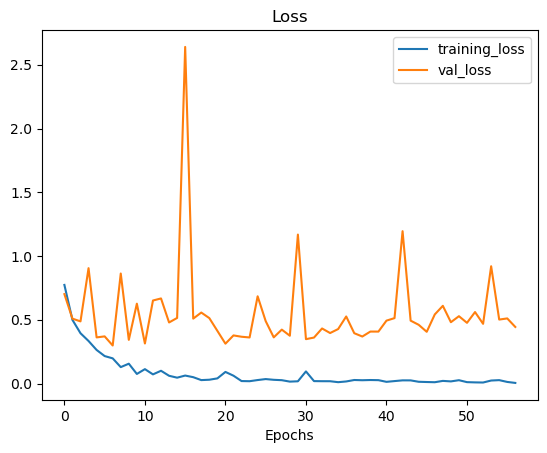

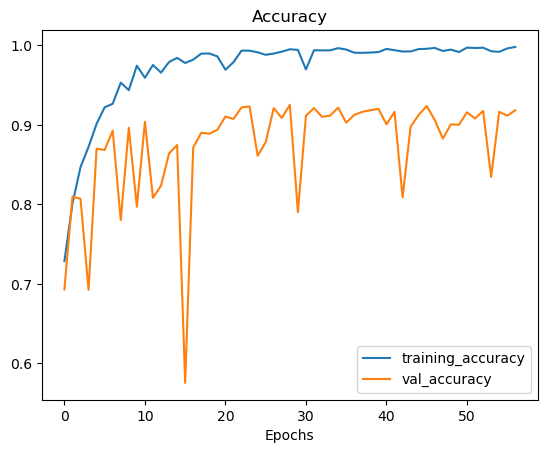

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [15]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 12 predictions: {pred[:12]}')

133/133 [==============================] - 30s 227ms/step
The first 12 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic']


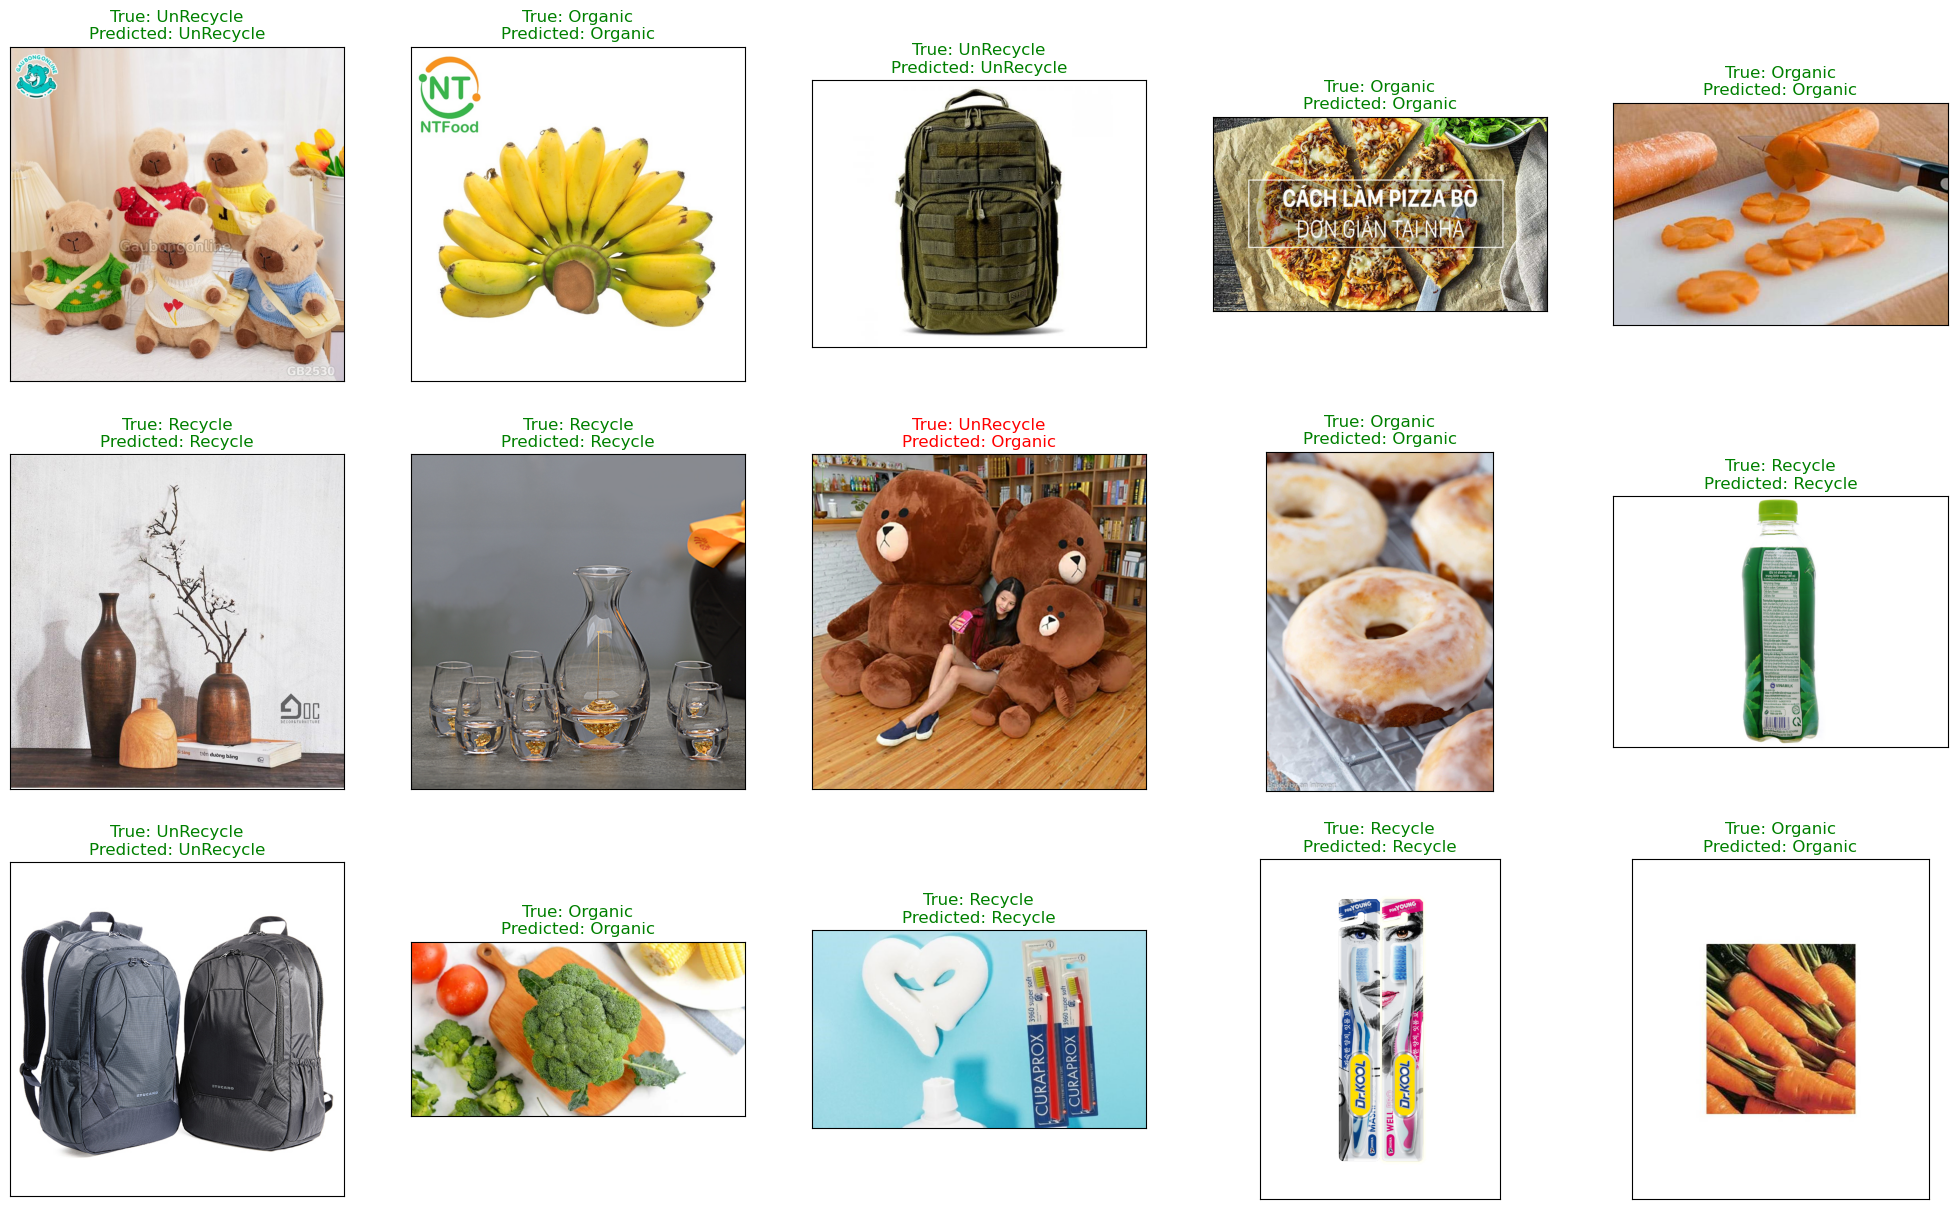

<Figure size 640x480 with 0 Axes>

In [16]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [17]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Organic,0.945646,0.957327,0.951451,1781.000000
Recycle,0.921532,0.905614,0.913503,1621.000000
UnRecycle,0.874251,0.880579,0.877404,829.000000
accuracy,0.922477,0.922477,0.922477,0.922477
macro avg,0.913810,0.914507,0.914119,4231.000000
weighted avg,0.922419,0.922477,0.922404,4231.000000


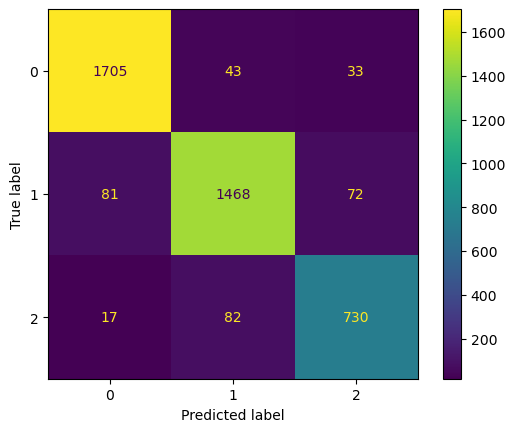

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()